In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import logging
import segyio
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import gc
from tqdm.notebook import tqdm

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.signal import butter, sosfilt
from devito import *
from copy import deepcopy
from distributed import Client, wait, LocalCluster
from skimage.metrics import structural_similarity as ssim

from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver

from devito_ta.model_geom import get_model, get_geometry, grad_utils
from devito_ta.prepro import Filter, filter_data, CustomSource
from devito_ta.simulation_born_ms import fm_multi_shots, grad_multi_shots, born_multi_shots, normalize
from devito_ta.prepro_dl import train, prepare_data
from devito_ta.plotting import plot_shotrecord_cust, plot_velocity_cust, plot_acquisition_geometry, plot_freq
from deeplearning_ta.attention_r2_unet import *


configuration['log-level'] = 'WARNING'
configuration['opt'] = 'advanced'
logging.getLogger('distributed.nanny').setLevel(logging.ERROR)

In [2]:
file = 'vp_marmousi-ii_10m.segy'

with segyio.open(file, "r", ignore_geometry=True) as ss:
    n_traces = ss.tracecount
    sample_rate = segyio.tools.dt(ss) / 1000
    n_samples =ss.samples.size
    twt = ss.samples
    data = ss.trace.raw[:] 

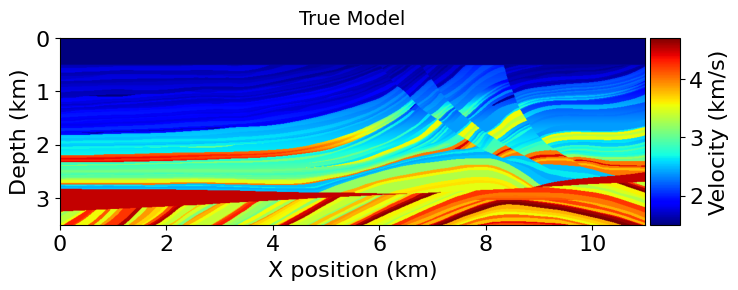

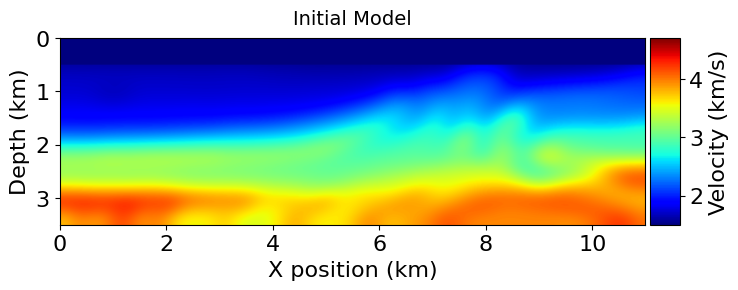

In [3]:
# Define water bottom depth in grid
wb = 50

# Define the model
v = data[200:1300, wb:].copy()             # Remove water layer

# Add water bottom to initial model
water_btm = np.ones((v.shape[0], wb)) * 1.5
v = np.concatenate([water_btm, v], axis=1)
minv = v.min()
maxv = v.max()

# Create initial model
init = gaussian_filter(v, sigma=[20, 20])  
init[:, :wb] = water_btm

init = np.clip(init, a_min=1.5, a_max=4.5)

# Get model

shape = (1100, 351)
spacing = (10, 10)
origin = (0, 0)

model1 = get_model(np.clip(v, 1.5, 5), shape, spacing, origin)
model0 = get_model(init, shape, spacing, origin)

# Plot velocity model
plot_velocity_cust(model1, colorbar=True, save=False, title='True Model', name='true_model')
plot_velocity_cust(model0, colorbar=True, save=False, title='Initial Model', name='init_model')


In [4]:
# Create new geometry for 50 shots
par = {'nx':1100,          'dx':10,       'ox':0,
       'nz':351,          'dz':10,       'oz':0,
       'ns':30,           'ds':300,      'os':2020.0,  'sz':0,
       'nr':200,          'dr':10.0,     'or':0,       'rz':0,
       'nt':4000,         'dt':1.18,        'ot':0,       'nof':20,
       'freq':10,
      }

# Sampling frequency
fs = 1 / (par['dt']/1000)

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz'] 

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz'] 

geometry1 = get_geometry(model=model1,
                         src_x=x_s[:, 0],
                         src_z=x_s[:, 1],
                         rec_x=x_r[:, 0],
                         rec_z=x_r[:, 1],
                         t0=0,
                         tn=par['nt'],
                         nof=par['nof'],
                         src_type='Ricker',
                         f0=par['freq']/1000,
                         dt=par['dt'])


n_workers = 6

cluster = LocalCluster(
    n_workers=n_workers,
    memory_limit='auto',
    threads_per_worker=4,
    death_timeout=600
)

client = Client(cluster)
client.restart()

/Users/dzianddafi/myenv/lib/python3.11/site-packages/distributed/deploy/spec.py:324: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54304 instead
  self.scheduler = cls(**self.scheduler_spec.get("options", {}))


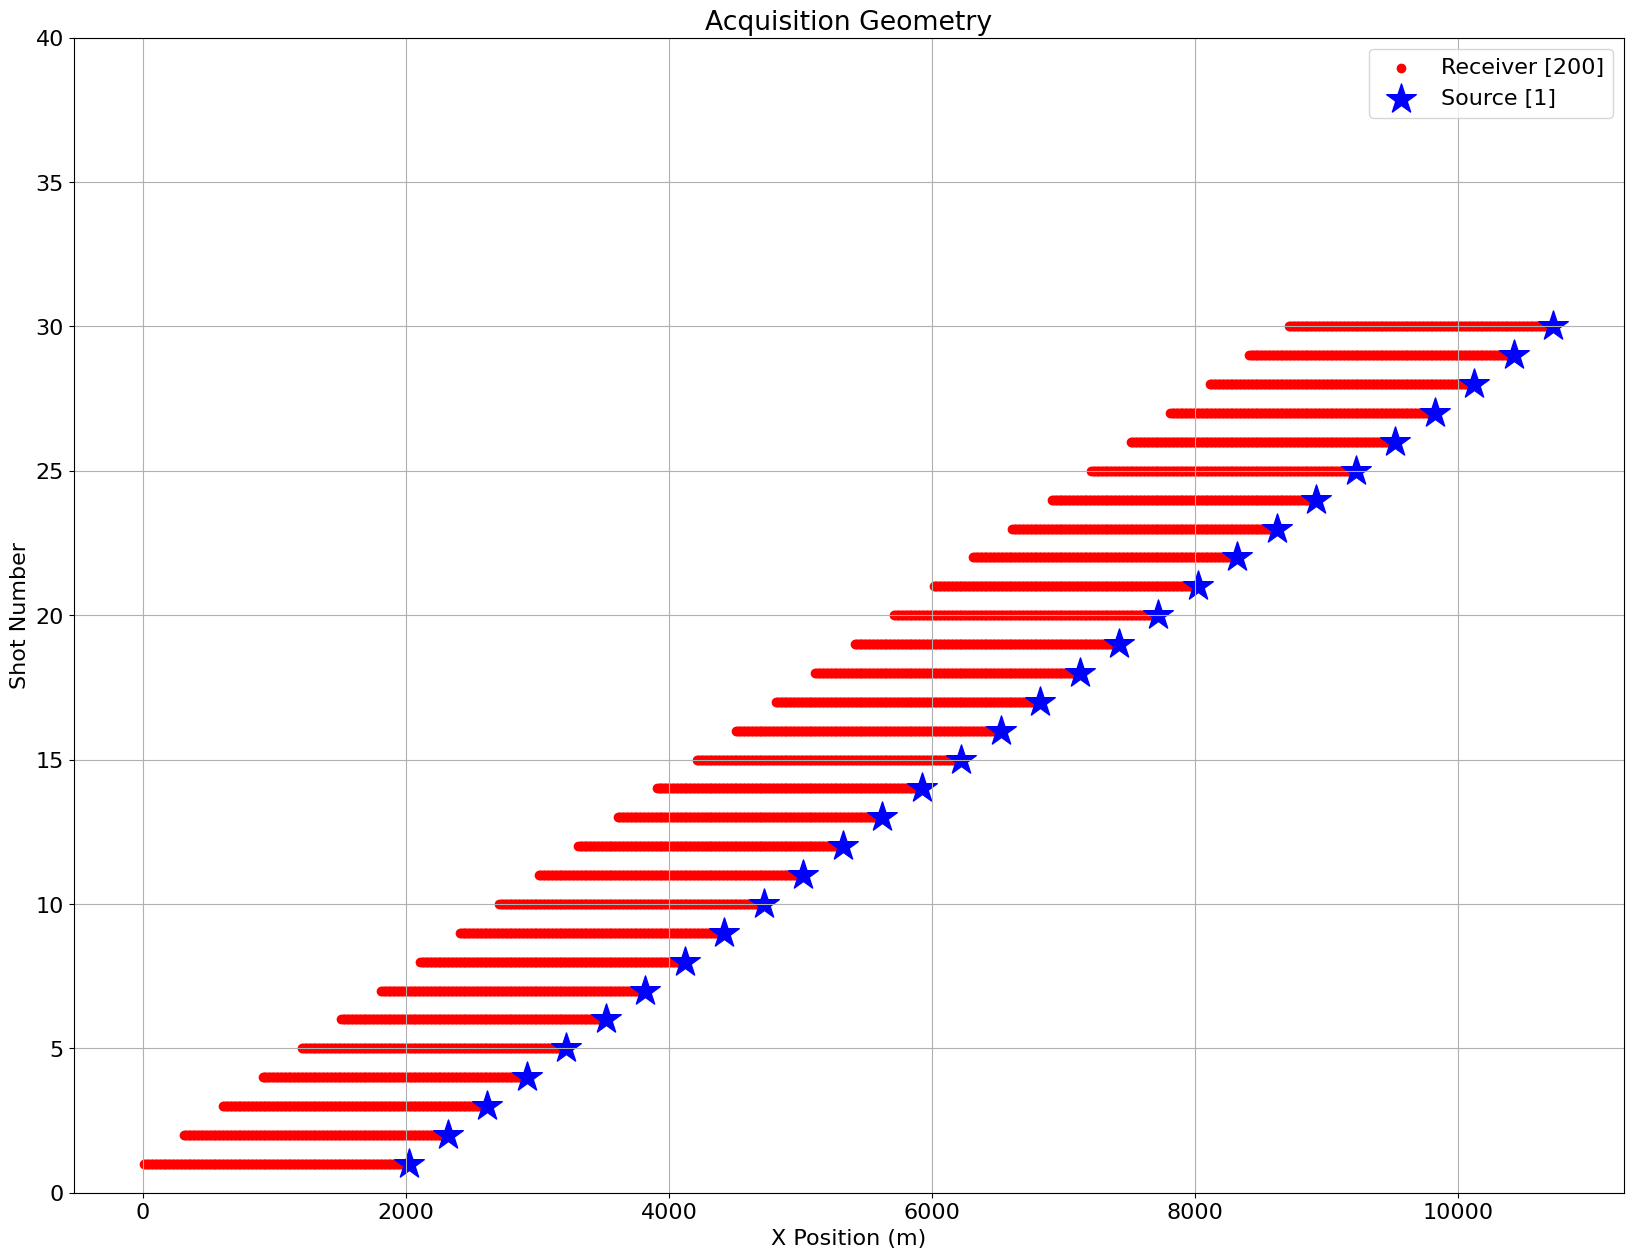

In [5]:
plot_acquisition_geometry(geometry1, 'Acquisition Geometry')

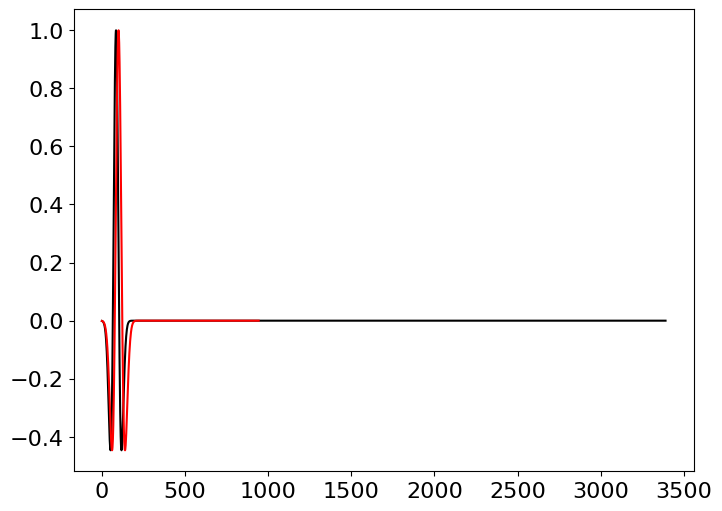

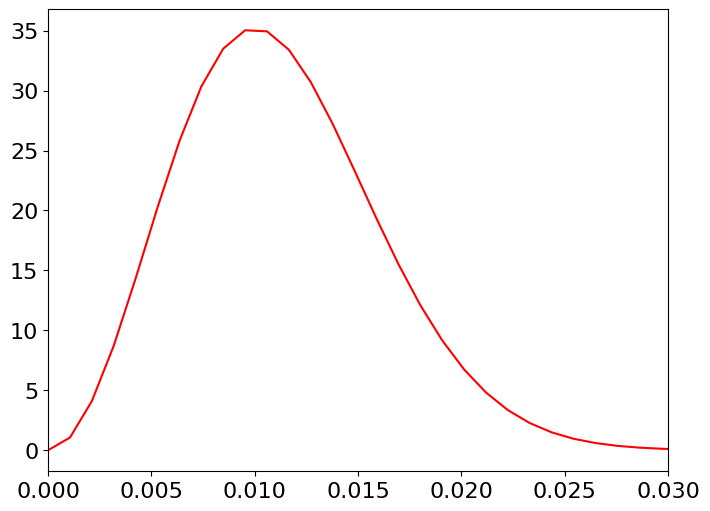

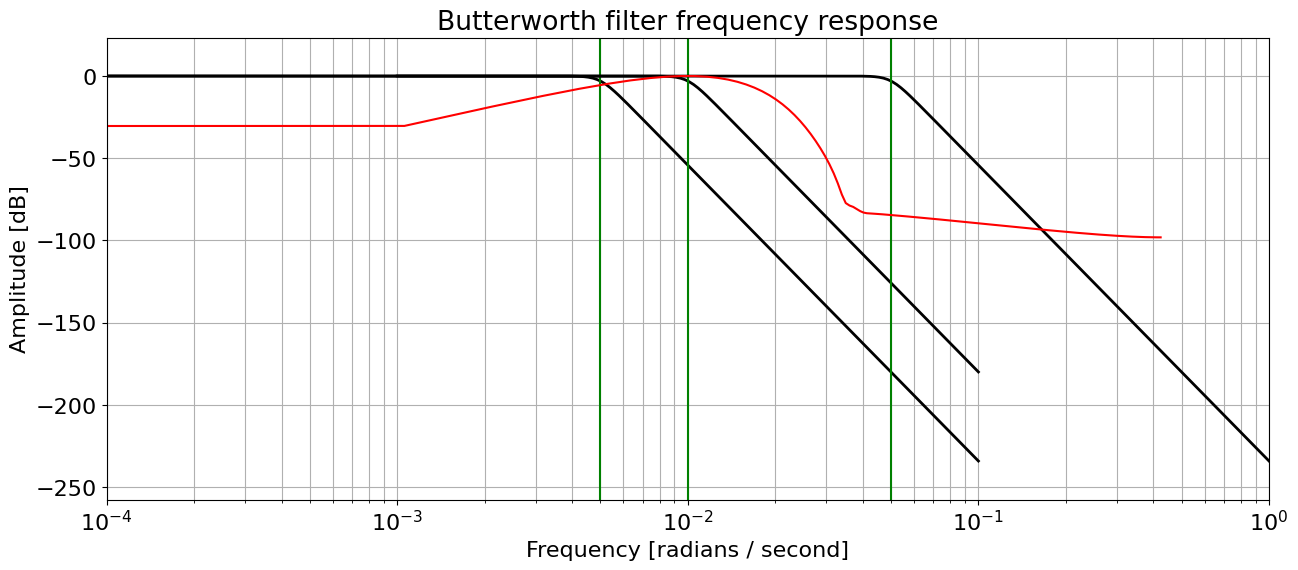

In [6]:
# The filtering phase is highly inspired by
# https://github.com/mrava87/Devito-fwi/blob/main/notebooks/acoustic/AcousticVel_L2_Nstages.ipynb
# Analyze source wavelet
nwav = 800
wav = geometry1[1].src.wavelet

f = np.fft.rfftfreq(nwav, par['dt'])
WAV = np.fft.rfft(wav[:nwav], nwav)

plt.figure()
plt.plot(wav, c='k')
plt.plot(geometry1[1].time_axis.time_values[:nwav], wav[:nwav], c='r')

plt.figure()
plt.plot(f, np.abs(WAV), c='r')
plt.xlim(0, par['freq']*3/1000)

# Params (3stages)
frequencies = [0.005, 0.01, 0.05]
nfilts = [9, 9, 9]
ftol = [1e-10, 1e-10, 1e-10]
maxiter = [50, 50, 50]
maxfun = [200, 200, 200]


# Extract wavelet and pad it to allow filtering
wavpad = 400
wav = wav[:2*np.argmax(wav)+1]
wav = np.pad(wav, (wavpad, geometry1[0].nt - wavpad - wav.size))

# Define filter
nfft = 2**10

plt.figure(figsize=(15, 6))
Filt = Filter(frequencies, nfilts, par['dt'], plotflag=True)

# plot frequency response in dB
plt.semilogx(f, 20*np.log10(np.abs(WAV)/np.max(np.abs(WAV))) , 'r')

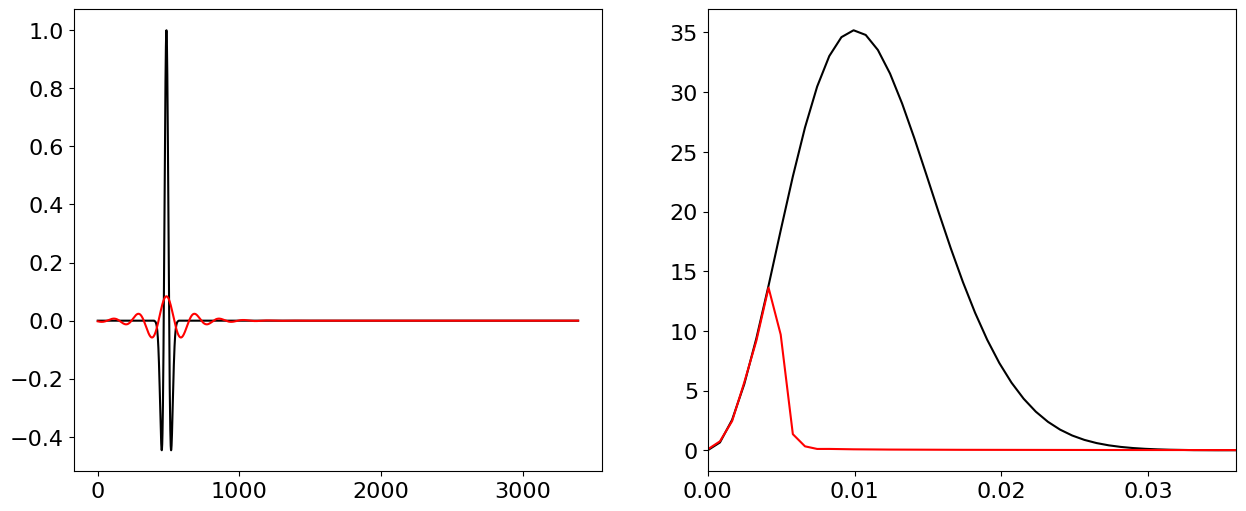

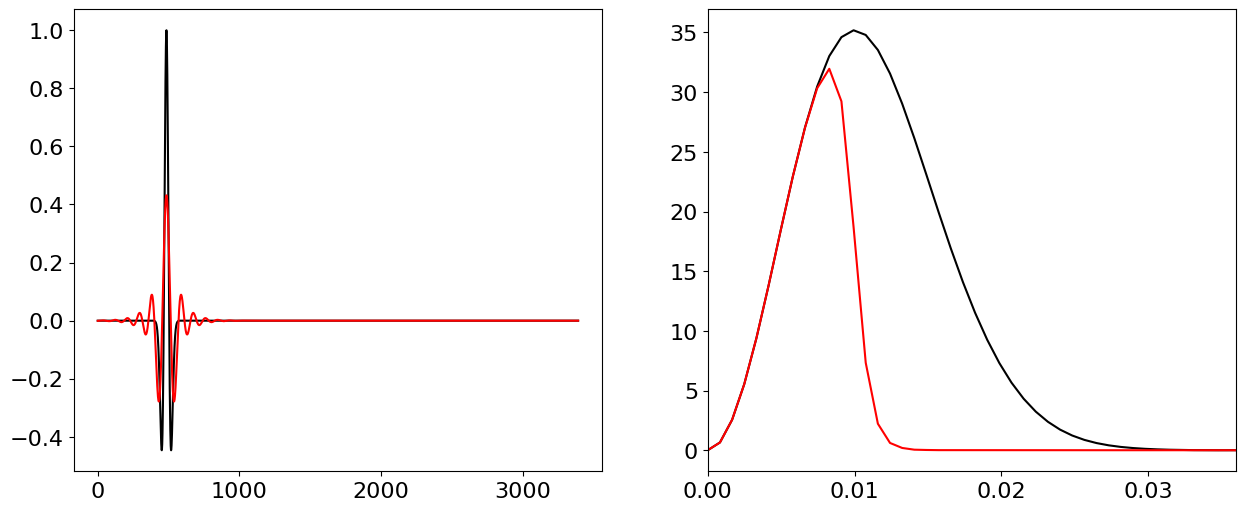

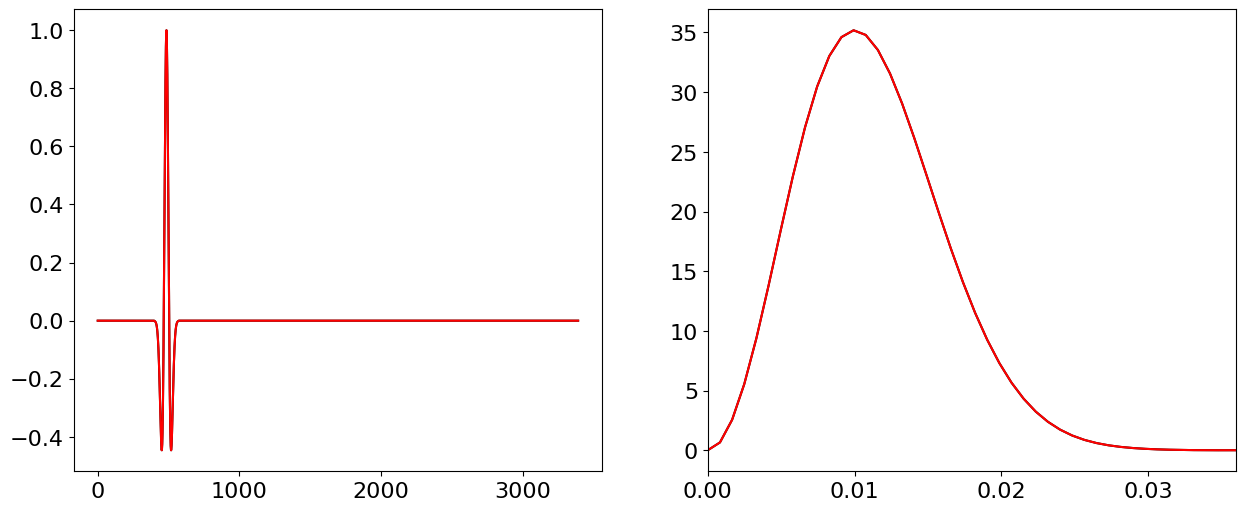

In [7]:
for i in range(len(frequencies)):
    
    wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=i)
    
    f = np.fft.rfftfreq(nfft, par['dt'])
    WAV = np.fft.rfft(wav, nfft)
    WAVfilt = np.fft.rfft(wavfilt, nfft)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(wav, 'k')
    axs[0].plot(wavfilt, 'r')
    axs[1].plot(f, np.abs(WAV), 'k')
    axs[1].plot(f, np.abs(WAVfilt), 'r')
    axs[1].set_xlim(0, np.argmax(np.abs(WAV))/1000*3);

In [ ]:
# Perform forward modelling at 10 Hz
dt = par['dt']

start_10hz = time.time()
fm = fm_multi_shots(model1, geometry1, n_workers, client, dt=dt)
finish_10hz = time.time()


In [ ]:
# Get observed data
dobs = [d.data for d, _ in fm]

# Show unfiltered data
plot_shotrecord_cust(dobs[0].data, f'Data at {geometry1[0].src_positions[0][0].item()} m',
                     dobs[14].data, f'Data at {geometry1[14].src_positions[0][0].item()} m',
                     dobs[-1].data, f'Data at {geometry1[-1].src_positions[0][0].item()} m',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

In [ ]:
# Filtering

# Params (3stages)
frequencies = [0.005, 0.01, 0.05] #in KHz
nfilts = [9, 9, 9]
ftol = [1e-10, 1e-10, 1e-10]
maxiter = [50, 50, 50]
maxfun = [200, 200, 200]
nwav = 800

wav = geometry1[1].src.wavelet

f = np.fft.rfftfreq(nwav, par['dt'])
WAV = np.fft.rfft(wav[:nwav], nwav)

# Plot original wavelet
plt.figure()
plt.plot(wav, c='k')
plt.plot(geometry1[1].time_axis.time_values[:nwav], wav[:nwav], c='r')

plt.figure()
plt.plot(f, np.abs(WAV), c='r')
plt.xlim(0, par['freq']*3/1000)

# Extract wavelet and pad it to allow filtering
wavpad = 400
wav = wav[:2*np.argmax(wav)+1]
wav = np.pad(wav, (wavpad, geometry1[0].nt - wavpad - wav.size))

# Define filter
nfft = 2**10

plt.figure(figsize=(15, 6))
Filt = Filter(frequencies, nfilts, par['dt'], plotflag=True)
plt.semilogx(f, 20*np.log10(np.abs(WAV)) - 28, 'r')

# Filter wavelet
wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=0)
src = CustomSource(name='src', grid=model1.grid,
                               wav=wavfilt, npoint=1,
                               time_range=geometry1[0].time_axis)

plt.plot(wav)
plt.plot(src.data)

# Shot wavelet result
for i in range(len(frequencies)):
    
    wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=i)
    
    f = np.fft.rfftfreq(nfft, par['dt'])
    WAV = np.fft.rfft(wav, nfft)
    WAVfilt = np.fft.rfft(wavfilt, nfft)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(wav, 'k')
    axs[0].plot(wavfilt, 'r')
    axs[1].plot(f, np.abs(WAV), 'k')
    axs[1].plot(f, np.abs(WAVfilt), 'r')
    axs[1].set_xlim(0, np.argmax(np.abs(WAV))/1000*3)

# Filter data
# Get observed data
dobs = [d.data for d, _ in fm]

# Show unfiltered data
plot_shotrecord_cust(dobs[0].data, 'Data at shot=1',
                     dobs[14].data, 'Data at shot=15',
                     dobs[-1].data, 'Data at shot=30',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

dobsfilt1 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=0).T[None, :] for isrc in range(par['ns'])])
dobsfilt2 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=1).T[None, :] for isrc in range(par['ns'])])
dobsfilt3 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=2).T[None, :] for isrc in range(par['ns'])])

# Show filtered data
plot_shotrecord_cust(dobsfilt1[19].data, 'Filtered to 0-5 Hz',
                     dobsfilt2[19].data, 'Filtered to 0-10 Hz',
                     dobsfilt3[19].data, 'Filtered to 0-20 Hz',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

# Frequency analysis
shotnum = 10
rec = 25
plot_freq(nwav,
          dobsfilt1[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

plot_freq(nwav,
          dobsfilt2[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')
plot_freq(nwav,
          dobsfilt3[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

plot_freq(nwav,
          geometry1[0].src.wavelet,
          geometry1[0].src.wavelet,
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

In [13]:
dobs1 = []
dobs2 = []
dobs3 = []

# Store matrix in receiver
for i in range(len(dobsfilt1)):
    # Buat Receiver baru
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Isi Receiver dengan data dobsfilt1[i]
    d_obs.data[:] = dobsfilt1[i]

    # Tambahkan ke list
    dobs1.append(d_obs)

for i in range(len(dobsfilt2)):
    # Buat Receiver baru
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Isi Receiver dengan data dobsfilt1[i]
    d_obs.data[:] = dobsfilt2[i]

    # Tambahkan ke list
    dobs2.append(d_obs)

for i in range(len(dobsfilt3)):
    # Buat Receiver baru
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Isi Receiver dengan data dobsfilt1[i]
    d_obs.data[:] = dobsfilt3[i]

    # Tambahkan ke list
    dobs3.append(d_obs)

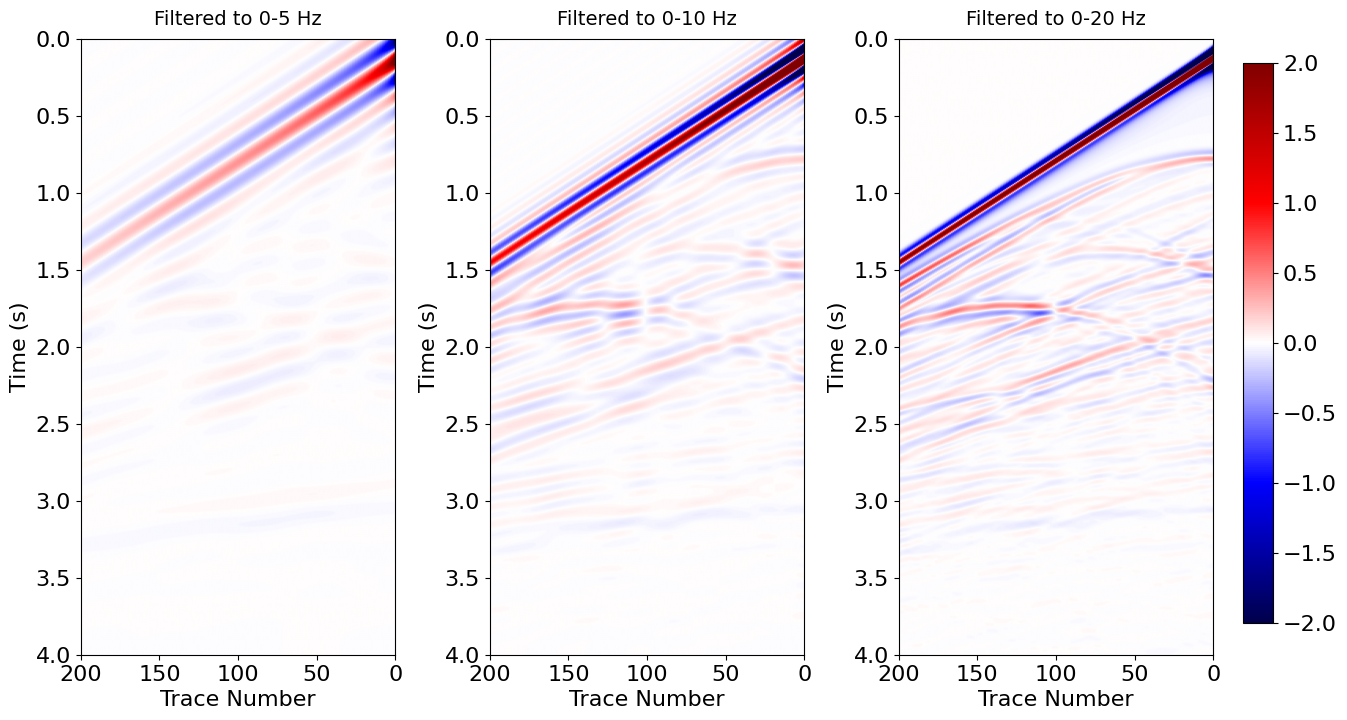

In [14]:
plot_shotrecord_cust(dobs1[19].data, 'Filtered to 0-5 Hz',
                     dobs2[19].data, 'Filtered to 0-10 Hz',
                     dobs3[19].data, 'Filtered to 0-20 Hz',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)


In [ ]:
nbl = model0.nbl
vpn = model0.vp.data[nbl:-nbl, nbl:-nbl]
vpt = model1.vp.data[nbl:-nbl, nbl:-nbl]

loss_mse = torch.nn.MSELoss()
loss_mae = torch.nn.L1Loss()

# Test parameter
loss_mse(torch.Tensor(vpn), torch.Tensor(vpt)).item()
ssim(vpn, vpt, data_range=vpn.max()-vpt.min()).item()

# Create wrapper for SciPy
def loss_func(x, model_true, geoms, n_workers, client, d_true, freq, nfilt, loss_hist, fpath):

    model_up = get_model(x.reshape(model_true.shape), shape, spacing, origin)
    
    client.restart(wait_for_workers=False)
    loss, grad = grad_multi_shots(model_true, model_up, geoms, n_workers, client, d_true, freq, nfilt)
    loss_hist.append(loss)

    np.savetxt(f'{fpath}/loss_monitor.txt', loss_hist)
    np.savetxt(f'{fpath}/grad_monitor.txt', grad)
    
    return loss, grad.flatten().astype(np.float64)

# Callback to track model misfit
def fwi_callback(xk, tr_vp, mse_hist, mae_hist, ssim_hist, fpath):

    update_vp = xk.reshape(tr_vp.shape)
    update_vp = np.clip(update_vp, minv, maxv)
    true_vp = np.clip(tr_vp, minv, maxv)
    assert update_vp.shape == true_vp.shape

    mseloss = loss_mse(torch.Tensor(update_vp), torch.Tensor(true_vp)).item()
    maeloss = loss_mae(torch.Tensor(update_vp), torch.Tensor(true_vp)).item()
    ssimval = ssim(update_vp, true_vp, data_range=update_vp.max()-update_vp.min()).item()
    mse_hist.append(mseloss)
    mae_hist.append(maeloss)
    ssim_hist.append(ssimval)

    # Save first update and monitor model   
    first_model_path = f'{fpath}/first_model.txt'
    if not os.path.exists(first_model_path):
        np.savetxt(f'{fpath}/first_model.txt', update_vp)
    else:
        np.savetxt(f'{fpath}/model_monitor.txt', update_vp)
        np.savetxt(f'{fpath}/vp_mse_monitor.txt', mse_hist)
        np.savetxt(f'{fpath}/vp_mae_monitor.txt', mae_hist)
        np.savetxt(f'{fpath}/ssim_monitor.txt', ssim_hist)
    

### Scale 1

In [ ]:
from scipy import optimize

# FWI with Conjugate Gradient

# Set up parameters
nbl = model1.nbl
model_true = model1
model_init = model0
geoms = geometry1.copy()
d_true = dobsfilt1.copy()

# Set up hyperparameters
ftol = 10e-10
gtol = 10e-10
maxiter = 30
maxls =10
blur = 3

freq = 0.005
nfilt = 9

# Set up storage
fpath = f'model_progress/marm_cg_multiscale/scale1'
vp_mse1, vp_mae1, ssim1 = [], [], []
seis_loss1 = []

# Initial guess
v0 = model_init.vp.data[nbl:-nbl, nbl:-nbl]
m0 = v0.reshape(-1).astype(np.float64)

# Box contraints
vmin = v.min()   
vmax = v.max()
bounds = [(vmin, vmax) for _ in range(np.prod(model0.shape))]

# Get and store initial gradient, loss, and misfit value
loss, grad0 = grad_multi_shots(model_true, model_init, geoms, n_workers, client, d_true, freq, nfilt)
grad0 = normalize(grad0, model_init.vp.data[nbl:-nbl,nbl:-nbl])

vp_true = model_true.vp.data[nbl:-nbl, nbl:-nbl].copy()
update_vp = np.clip(v0, minv, maxv)

mseloss = loss_mse(torch.Tensor(update_vp), torch.Tensor(vp_true)).item()
maeloss = loss_mae(torch.Tensor(update_vp), torch.Tensor(vp_true)).item()
ssimval = ssim(update_vp, vp_true, data_range=update_vp.max()-update_vp.min()).item()
vp_mse1.append(mseloss)
vp_mae1.append(maeloss)
ssim1.append(ssimval)

np.savetxt(f'{fpath}/grad_first.txt', grad0)

# Run inversion with CG
start_inv = time.time()
result1 = optimize.minimize(loss_func, m0, 
                            args=(model_true, geoms, n_workers, client, d_true, freq, nfilt, seis_loss1, fpath),
                            method='CG', 
                            jac=True,
                            callback=lambda x: fwi_callback(x, vp_true, vp_mse1, vp_mae1, ssim1, fpath), 
                            options={'maxiter': maxiter,
                                     'gtol'   : gtol,
                                     'disp'   : True}
                           )

# Store model, gradient, and misfit value
model_vp_optim1 = result1.x.reshape(model1.shape)
np.savetxt(f'{fpath}/model_final.txt', model_vp_optim1)
model_up1 = get_model(model_vp_optim1, shape, spacing, origin)

grad_optim1 = result1.jac.reshape(model1.shape)
np.savetxt(f'{fpath}/grad_final.txt', grad_optim1)

finish_inv = time.time()
duration_inv = finish_inv - start_inv

In [18]:
print(f'Duration for inversion with CG-PR at scale 1: {(duration_inv/3600):.2f} hrs')

Duration for inversion with CG-PR at scale 1: 1.66 hrs


### Scale 2

In [ ]:
from scipy import optimize

# FWI with Conjugate Gradient
# Set up parameters
nbl = model1.nbl
model_true = deepcopy(model1)
model_init = deepcopy(model_up1)
geoms = geometry1.copy()
d_true = dobsfilt2.copy()

# Set up hyperparameters
ftol = 10e-10
gtol = 10e-10
maxiter = 30
maxls = 10
blur = 3

freq = 0.01
nfilt = 9

# Set up storage
fpath = f'model_progress/marm_cg_multiscale/scale2'
vp_mse2, vp_mae2, ssim2 = [], [], []
seis_loss2 = []

# Initial guess
v0 = model_init.vp.data[nbl:-nbl, nbl:-nbl]
m0 = v0.reshape(-1).astype(np.float64)

# Box contraints
vmin = v.min()   
vmax = v.max()
bounds = [(vmin, vmax) for _ in range(np.prod(model0.shape))]

# Get and store initial gradient, loss, and misfit value
loss, grad0 = grad_multi_shots(model_true, model_init, geoms, n_workers, client, d_true, freq, nfilt)
grad0 = normalize(grad0, model_init.vp.data[nbl:-nbl,nbl:-nbl])

vp_true = model_true.vp.data[nbl:-nbl, nbl:-nbl].copy()
update_vp = np.clip(v0, minv, maxv)

mseloss = loss_mse(torch.Tensor(update_vp), torch.Tensor(vp_true)).item()
maeloss = loss_mae(torch.Tensor(update_vp), torch.Tensor(vp_true)).item()
ssimval = ssim(update_vp, vp_true, data_range=update_vp.max()-update_vp.min()).item()
vp_mse2.append(mseloss)
vp_mae2.append(maeloss)
ssim2.append(ssimval)

np.savetxt(f'{fpath}/grad_first.txt', grad0)

# Run inversion with CG
start_inv = time.time()
result2 = optimize.minimize(loss_func, m0, 
                            args=(model_true, geoms, n_workers, client, d_true, freq, nfilt, seis_loss2, fpath),
                            method='CG', 
                            jac=True,
                            callback=lambda x: fwi_callback(x, vp_true, vp_mse2, vp_mae2, ssim2, fpath), 
                            options={'maxiter': maxiter,
                                     'gtol'   : gtol,
                                     'disp'   : True}
                           )

# Store model, gradient, and misfit value
model_vp_optim2 = result2.x.reshape(model1.shape)
np.savetxt(f'{fpath}/model_final.txt', model_vp_optim2)
model_up2 = get_model(model_vp_optim2, shape, spacing, origin)

grad_optim2 = result2.jac.reshape(model1.shape)
np.savetxt(f'{fpath}/grad_final.txt', grad_optim2)

finish_inv = time.time()
duration_inv = finish_inv - start_inv

In [20]:
print(f'Duration for inversion with CG-PR at scale 2: {(duration_inv/3600):.2f} hrs')

Duration for inversion with CG-PR at scale 2: 1.58 hrs


### Scale 3

In [ ]:
from scipy import optimize

# FWI with Conjugate Gradient
# Set up parameters
nbl = model1.nbl
model_true = model1
model_init = model_up2
geoms = geometry1.copy()
d_true = dobsfilt3.copy()

# Set up hyperparameters
ftol = 10e-10
gtol = 10e-10
maxiter = 30
maxls = 10
blur = 3

freq = 0.05
nfilt = 9

# Set up storage
fpath = f'model_progress/marm_cg_multiscale/scale3'
vp_mse3, vp_mae3, ssim3 = [], [], []
seis_loss3 = []

# Initial guess
v0 = model_init.vp.data[nbl:-nbl, nbl:-nbl]
m0 = v0.reshape(-1).astype(np.float64)

# Box contraints
vmin = v.min()   
vmax = v.max()
bounds = [(vmin, vmax) for _ in range(np.prod(model0.shape))]

# Get and store initial gradient, loss, and misfit value
loss, grad0 = grad_multi_shots(model_true, model_init, geoms, n_workers, client, d_true, freq, nfilt)
grad0 = normalize(grad0, model_init.vp.data[nbl:-nbl,nbl:-nbl])

vp_true = model_true.vp.data[nbl:-nbl, nbl:-nbl].copy()
update_vp = np.clip(v0, minv, maxv)

mseloss = loss_mse(torch.Tensor(update_vp), torch.Tensor(vp_true)).item()
maeloss = loss_mae(torch.Tensor(update_vp), torch.Tensor(vp_true)).item()
ssimval = ssim(update_vp, vp_true, data_range=update_vp.max()-update_vp.min()).item()
vp_mse3.append(mseloss)
vp_mae3.append(maeloss)
ssim3.append(ssimval)

np.savetxt(f'{fpath}/grad_first.txt', grad0)

# Run inversion with CG
start_inv = time.time()
result3 = optimize.minimize(loss_func, m0, 
                            args=(model_true, geoms, n_workers, client, d_true, freq, nfilt, seis_loss3, fpath),
                            method='CG', 
                            jac=True,
                            callback=lambda x: fwi_callback(x, vp_true, vp_mse3, vp_mae3, ssim3, fpath), 
                            options={'maxiter': maxiter,
                                     'gtol'   : gtol,
                                     'disp'   : True}
                           )

# Store model, gradient, and misfit value
model_vp_optim3 = result3.x.reshape(model1.shape)
np.savetxt(f'{fpath}/model_final.txt', model_vp_optim3)
model_up3 = get_model(model_vp_optim3, shape, spacing, origin)

grad_optim3 = result3.jac.reshape(model1.shape)
np.savetxt(f'{fpath}/grad_final.txt', grad_optim3)

finish_inv = time.time()
duration_inv = finish_inv - start_inv

In [22]:
print(f'Duration for inversion with CG-PR at scale 3: {(duration_inv/3600):.2f} hrs')

Duration for inversion with CG-PR at scale 3: 2.08 hrs


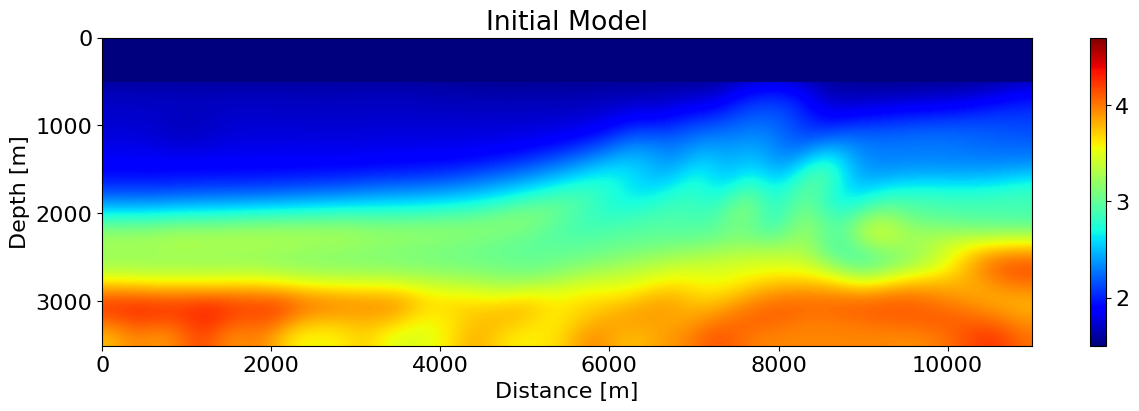

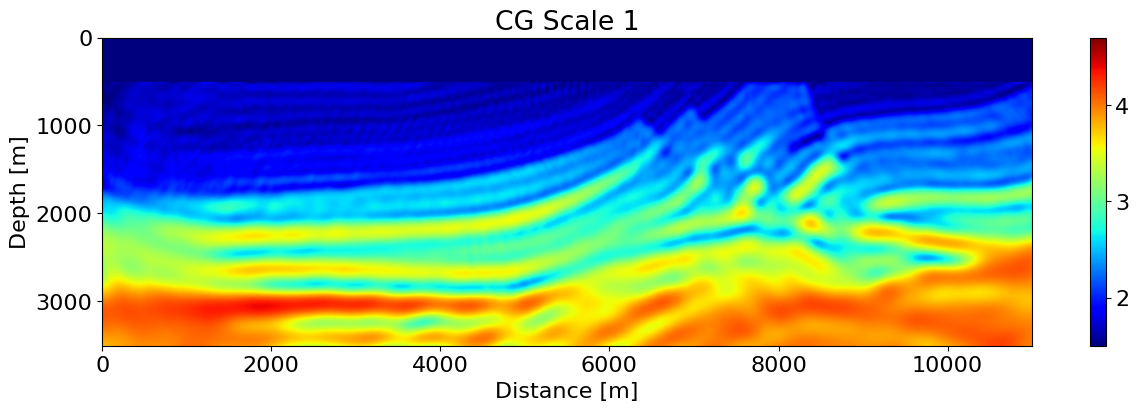

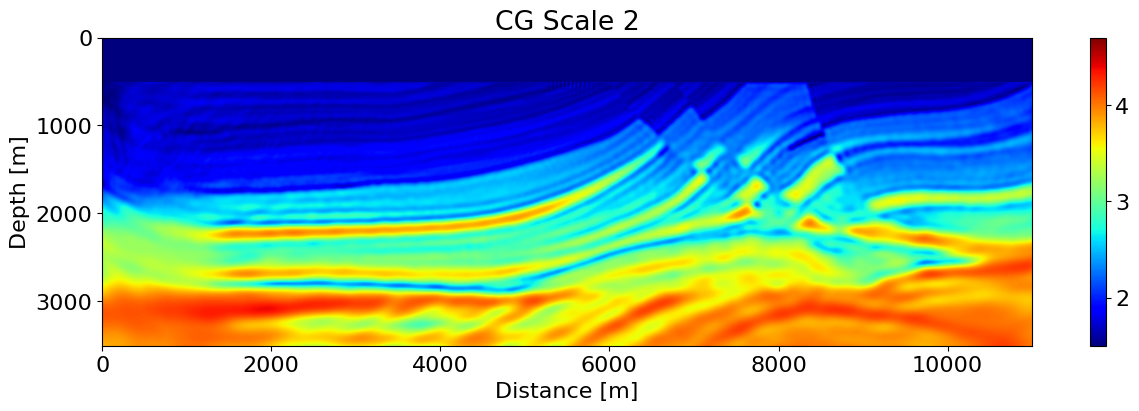

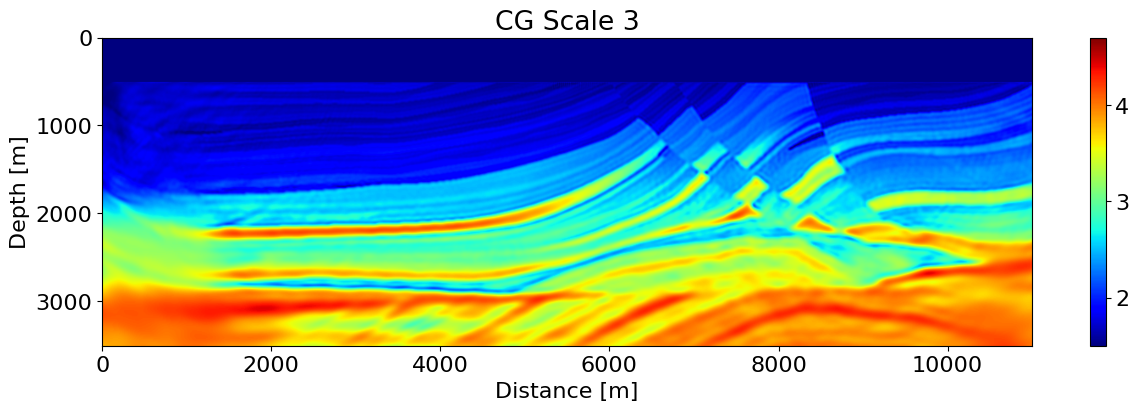

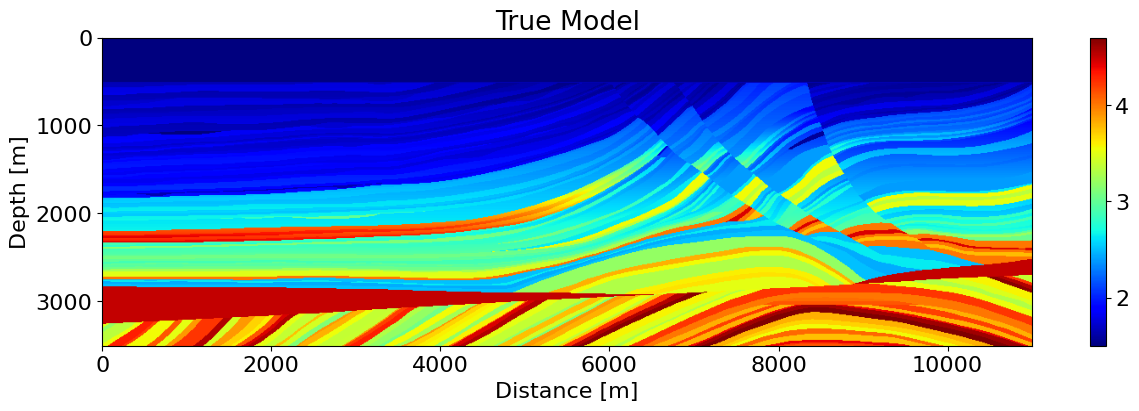

2025-10-17 04:58:46,663 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 16.04 GiB -- Worker memory limit: 21.33 GiB
2025-10-17 05:03:46,664 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 16.03 GiB -- Worker memory limit: 21.33 GiB
2025-10-17 05:08:46,664 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

In [23]:
vp1 = np.loadtxt(f'model_progress/marm_cg_multiscale/scale1/model_final.txt').T
vp2 = np.loadtxt(f'model_progress/marm_cg_multiscale/scale2/model_final.txt').T
vp3 = np.loadtxt(f'model_progress/marm_cg_multiscale/scale3/model_final.txt').T

shape = (1100, 351)
spacing = (10, 10)
origin = (0, 0)

vm = 0.1
shrink=1
figsize=(15,4)
extent = (0, 11000, 3510, 0)

plt.figure(figsize=figsize)
plt.title('Initial Model')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(init[:1100].T, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('CG Scale 1')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp1, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('CG Scale 2')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp2, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('CG Scale 3')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp3, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('True Model')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(v[:1100].T, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.show()